In [1]:
include("../src/Granulars.jl")
using BenchmarkTools
using Plots

# Benchmark

Taken from this paper:

## Quaternion-based rigid body rotation integration algorithms for use in particle methods

We have a cilinder with the following innertia components in the principal axis frame:
\begin{equation}
    I = (2, 2, 1)
\end{equation}

The initial angular velocity will in the inertial reference frame:
\begin{equation}
    \vec{\omega} = (100, 1, 0)
\end{equation}

Whith an initial orientation of
\begin{equation}
    \vec{\theta} = (1, 0, 0)
\end{equation}

Then, the analityc solution of the cilinder orientation is

\begin{equation}
    \begin{split}
        & \vec{x} = \vec{\omega}_0 + r \cos{(|\vec{\omega}|t)}\;\cdot \left( (\vec{\psi}\cdot\hat{i})\hat{i}  + (\vec{\psi}\cdot\hat{j})\hat{j} +r\sin{(|\vec{\omega}|t)}\hat{k} \right) \\
        & r = \sqrt{1 - \vec{\omega}_0\cdot\hat{i}} \\
        & \vec{\omega}_0 = \left(\frac{\vec{\omega}}{|\vec{\omega}|}\cdot\hat{i}\right)\frac{\vec{\omega}}{|\vec{\omega}|}\\
        & \vec{\psi} = \frac{\vec{\omega}}{|\vec{\omega}|}\times\hat{k}\\
    \end{split}
\end{equation}

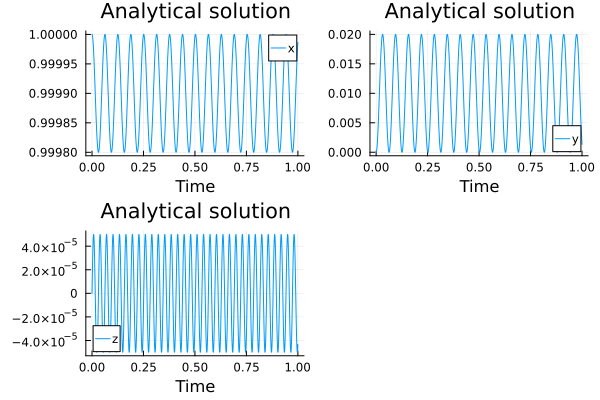

In [49]:
function sol(t)
    Vector{Float64}(ω0 + r*cos(norm(ω)*t)*(dot(ψ,i)*i + dot(ψ,j)*j + r*sin(norm(ω)*t)*k))
end

# Inertial frame vectors
i = SVector(1.0, 0.0, 0.0)
j = SVector(0.0, 1.0, 0.0)
k = SVector(0.0, 0.0, 1.0)

# Initial Conditions
I = SVector(2.0, 2.0, 1.0)
τ = SVector(0.0, 0.0, 0.0)
ω = SVector(100.0, 1.0, 0.0)

# Solution variables
ψ = cross(normalize(ω), k)
ω0 = dot(normalize(ω), i)*normalize(ω)
r = sqrt(1 - dot(ω0, i))

# Initial orientation
x0 = sol(0.0)
q0 = angle_to_quat(EulerAngles(x0[1], x0[2], x0[3], :XYZ))

# Time spwan 
tmax = 1.0
dt = 1e-4
n_steps = Int64(tmax/dt)

t = LinRange(0.0, tmax, n_steps)
x = sol.(t)
x = reduce(hcat, x)'

l = @layout [3]
p1 = plot(t, x[:, 1], label="x")
p2 = plot(t, x[:, 2], label="y")
p3 = plot(t, x[:, 3], label="z")
plot(p1, p2, p3, layout = l, title="Analytical solution", ylable="Angle [rads]", xlabel="Time")

---

We are going to test 3 different integration algorithms aginst this analitical solution

In [50]:
function YADE_move_q(q::Quaternion{Float64}, w::SVector{3, Float64}, dt::Float64)::Quaternion{Float64}
    q + dquat(q, w)*dt
end

function YADE_move_w(w::SVector{3, Float64}, τ::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64, cte=1.0::Float64, niter=3::Int64)::SVector{3, Float64}
    w + SVector(
            τ[1]/II[1] + w[2]*w[3]*(II[2]-II[3])/II[1],
            τ[2]/II[2] + w[3]*w[1]*(II[3]-II[1])/II[2],
            τ[3]/II[3] + w[1]*w[2]*(II[1]-II[2])/II[3])*dt*cte
end
function YADE_time_step(q,w,τ,II,dt)
    w = YADE_move_w(w,τ,II,dt, 0.5)
    q = YADE_move_q(q,w,dt)
    w = YADE_move_w(w,τ,II,dt, 0.5)
    q, w
end

YADE_time_step (generic function with 1 method)

In [51]:
Yade_q = []

q = q0
w = ω

for i in 0:n_steps-1
    push!(Yade_q, q)
    q, w = YADE_time_step(q,w,τ,I,dt)
end

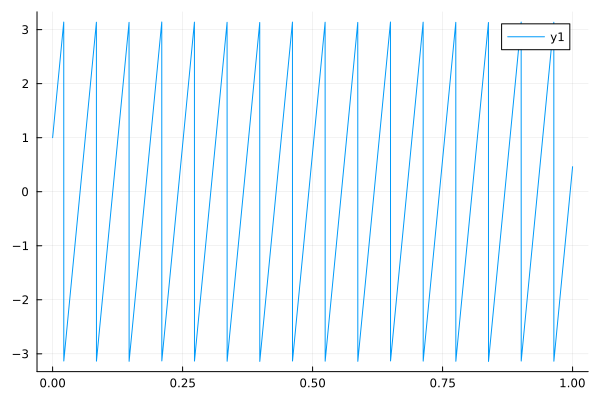

In [53]:
Yade_x = []

for i in eachindex(Yade_q)
    xx = quat_to_angle(Yade_q[i], :XYZ)
    push!(Yade_x, [xx.a1, xx.a2, xx.a3])
end

Yade_x = reduce(hcat, Yade_x)'

Yade_error = Yade_x[:, 1]
plot(t, Yade_error)